In [1]:
%load_ext autoreload
%autoreload 2

import argparse
import sys

import seaborn as sns
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split

from src.utils.experiment import *
from src.utils.function_vector import *
from src.utils.learnable_task_vector import *
from src.utils.plot import *
from src.eval import gen_orthogonal_train_test
from src.samplers import GaussianSampler, sample_transformation
from src.tasks import NoisyLinearRegression

sys.path.append("..")  # Adds higher directory to python modules path

SEED = 17
GPU_IDX = 0

sns.set(context='paper', style='ticks', palette='colorblind')

### Configure the experiment
##### Here, ``seq_len`` is the length of the prompts that the model was trained with. ``test_seq_len`` is the prompt lengths during the inference stage. We perform ours long sequence tests with ``test_seq_len > seq_len``. 

In [2]:
# Set the variables
task_name = "linear_regression"

batch_size = 256
seq_len = 86
test_seq_len = 96

act_fn = None

#### Configure the directories for loading/saving the models/figures

In [3]:
#  Set seeds
set_seed(SEED)
device = torch.device(f"cuda:{GPU_IDX}" if torch.cuda.is_available() else "cpu")

# Construct the running and saving paths
figures_path, preds_path = prepare_save_dirs(os.path.join(task_name, "results"))
run_path = os.path.join(f"./models", task_name, "pretrained")

experiment_dir = f"./src/LTV_models/{task_name}/{act_fn}/seq_len_{seq_len}"

if not os.path.exists(experiment_dir):
    raise ValueError("Invalid sequence length")

#### Initialize the trained model and obtain the necessary variables

In [4]:
# Prepare the model, get the task and data samplers, and save the parameters required later
model, conf, task_sampler, covariate_sampler, params = prepare_model(run_path, batch_size, device)
n_dims, resid_dim, n_layers, n_heads, head_dim = params

#### Sample a batch of prompts of length ``seq_len`` to compute FV and LTV on 

In [5]:
task = task_sampler()
xs_sample = covariate_sampler.sample_xs(b_size=batch_size, n_points=conf.training.curriculum.points.end).to(device)
ys_sample = task.evaluate(xs_sample).to(device)

#### Compute _indirect effects_ (required for FV, out-of-scope for us) and use it to compute FV

In [6]:
# Only for visualization
n_top_heads_visual = 10

# Compute the indirect
indirect_effect_mat = get_top_heads(model, xs_sample, ys_sample, n_layers, n_heads)
indirect_effect_mat_np = indirect_effect_mat.cpu().data.numpy()

top_heads = top_heads_locations(indirect_effect_mat_np, num_top_heads=35)
universal_mean_activations = get_universal_mean_act(model, xs_sample, ys_sample, n_layers, n_heads, head_dim)
FV = compute_function_vector(model, universal_mean_activations, top_heads, resid_dim, head_dim)

For layer 0 and attn. head 0 - indirect effect: -0.062
For layer 0 and attn. head 1 - indirect effect: 0.071
For layer 0 and attn. head 2 - indirect effect: 0.075
For layer 0 and attn. head 3 - indirect effect: 0.093
For layer 0 and attn. head 4 - indirect effect: 0.005
For layer 0 and attn. head 5 - indirect effect: -0.045
For layer 0 and attn. head 6 - indirect effect: -0.134
For layer 0 and attn. head 7 - indirect effect: 0.028
For layer 1 and attn. head 0 - indirect effect: 0.034
For layer 1 and attn. head 1 - indirect effect: 0.029
For layer 1 and attn. head 2 - indirect effect: -0.091
For layer 1 and attn. head 3 - indirect effect: -0.119
For layer 1 and attn. head 4 - indirect effect: 0.028
For layer 1 and attn. head 5 - indirect effect: 0.071
For layer 1 and attn. head 6 - indirect effect: -0.035
For layer 1 and attn. head 7 - indirect effect: 0.074
For layer 2 and attn. head 0 - indirect effect: -0.630
For layer 2 and attn. head 1 - indirect effect: 0.652
For layer 2 and attn.

#### Initialize the trained LTV layer and compute LTV

In [7]:
params_path = os.path.join(experiment_dir, f"ltv_layer_{seq_len}.pth")

ltv_layer = LearnableTaskVector(n_layers, n_heads).to(device)
ltv_layer.load_state_dict(torch.load(params_path))

model.eval()
ltv_layer.eval()

LearnableTaskVector()

In [8]:
with torch.no_grad():
    attn_out = get_attn_outs(model, xs_sample, ys_sample, n_layers, n_heads, head_dim, resid_dim)
    LTV = ltv_layer(attn_out)

#### Now, sample a batch of test prompts
#### These prompts can be long sequences or generated with out-of-distribution data

In [9]:
dist_shift = ''

if dist_shift == 'skewed':
    eigenvals = 1 / (torch.arange(n_dims) + 1)
    covar = sample_transformation(eigenvals, normalize=True)
    covariate_sampler = GaussianSampler(n_dims, bias=0, scale=covar)
    xs_test = covariate_sampler.sample_xs(b_size=batch_size, n_points=test_seq_len).to(device)
    ys_test = task.evaluate(xs_test).to(device)
elif dist_shift == 'noisy_linear_regression':
    if task_name != 'linear_regression':
        raise NotImplementedError("Noisy linear regression is requires linear regression models")
    else:
        task = NoisyLinearRegression(n_dims, batch_size)
        xs_test = covariate_sampler.sample_xs(b_size=batch_size, n_points=test_seq_len).to(device)
        ys_test = task.evaluate(xs_test).to(device)
elif dist_shift == 'orthogonal_query':
    _, xs_test = gen_orthogonal_train_test(covariate_sampler, test_seq_len, batch_size)
    xs_test = xs_test.to(device)
    ys_test = task.evaluate(xs_test).to(device)
else:
    xs_test = covariate_sampler.sample_xs(b_size=batch_size, n_points=test_seq_len).to(device)
    ys_test = task.evaluate(xs_test).to(device)

### On-distribution

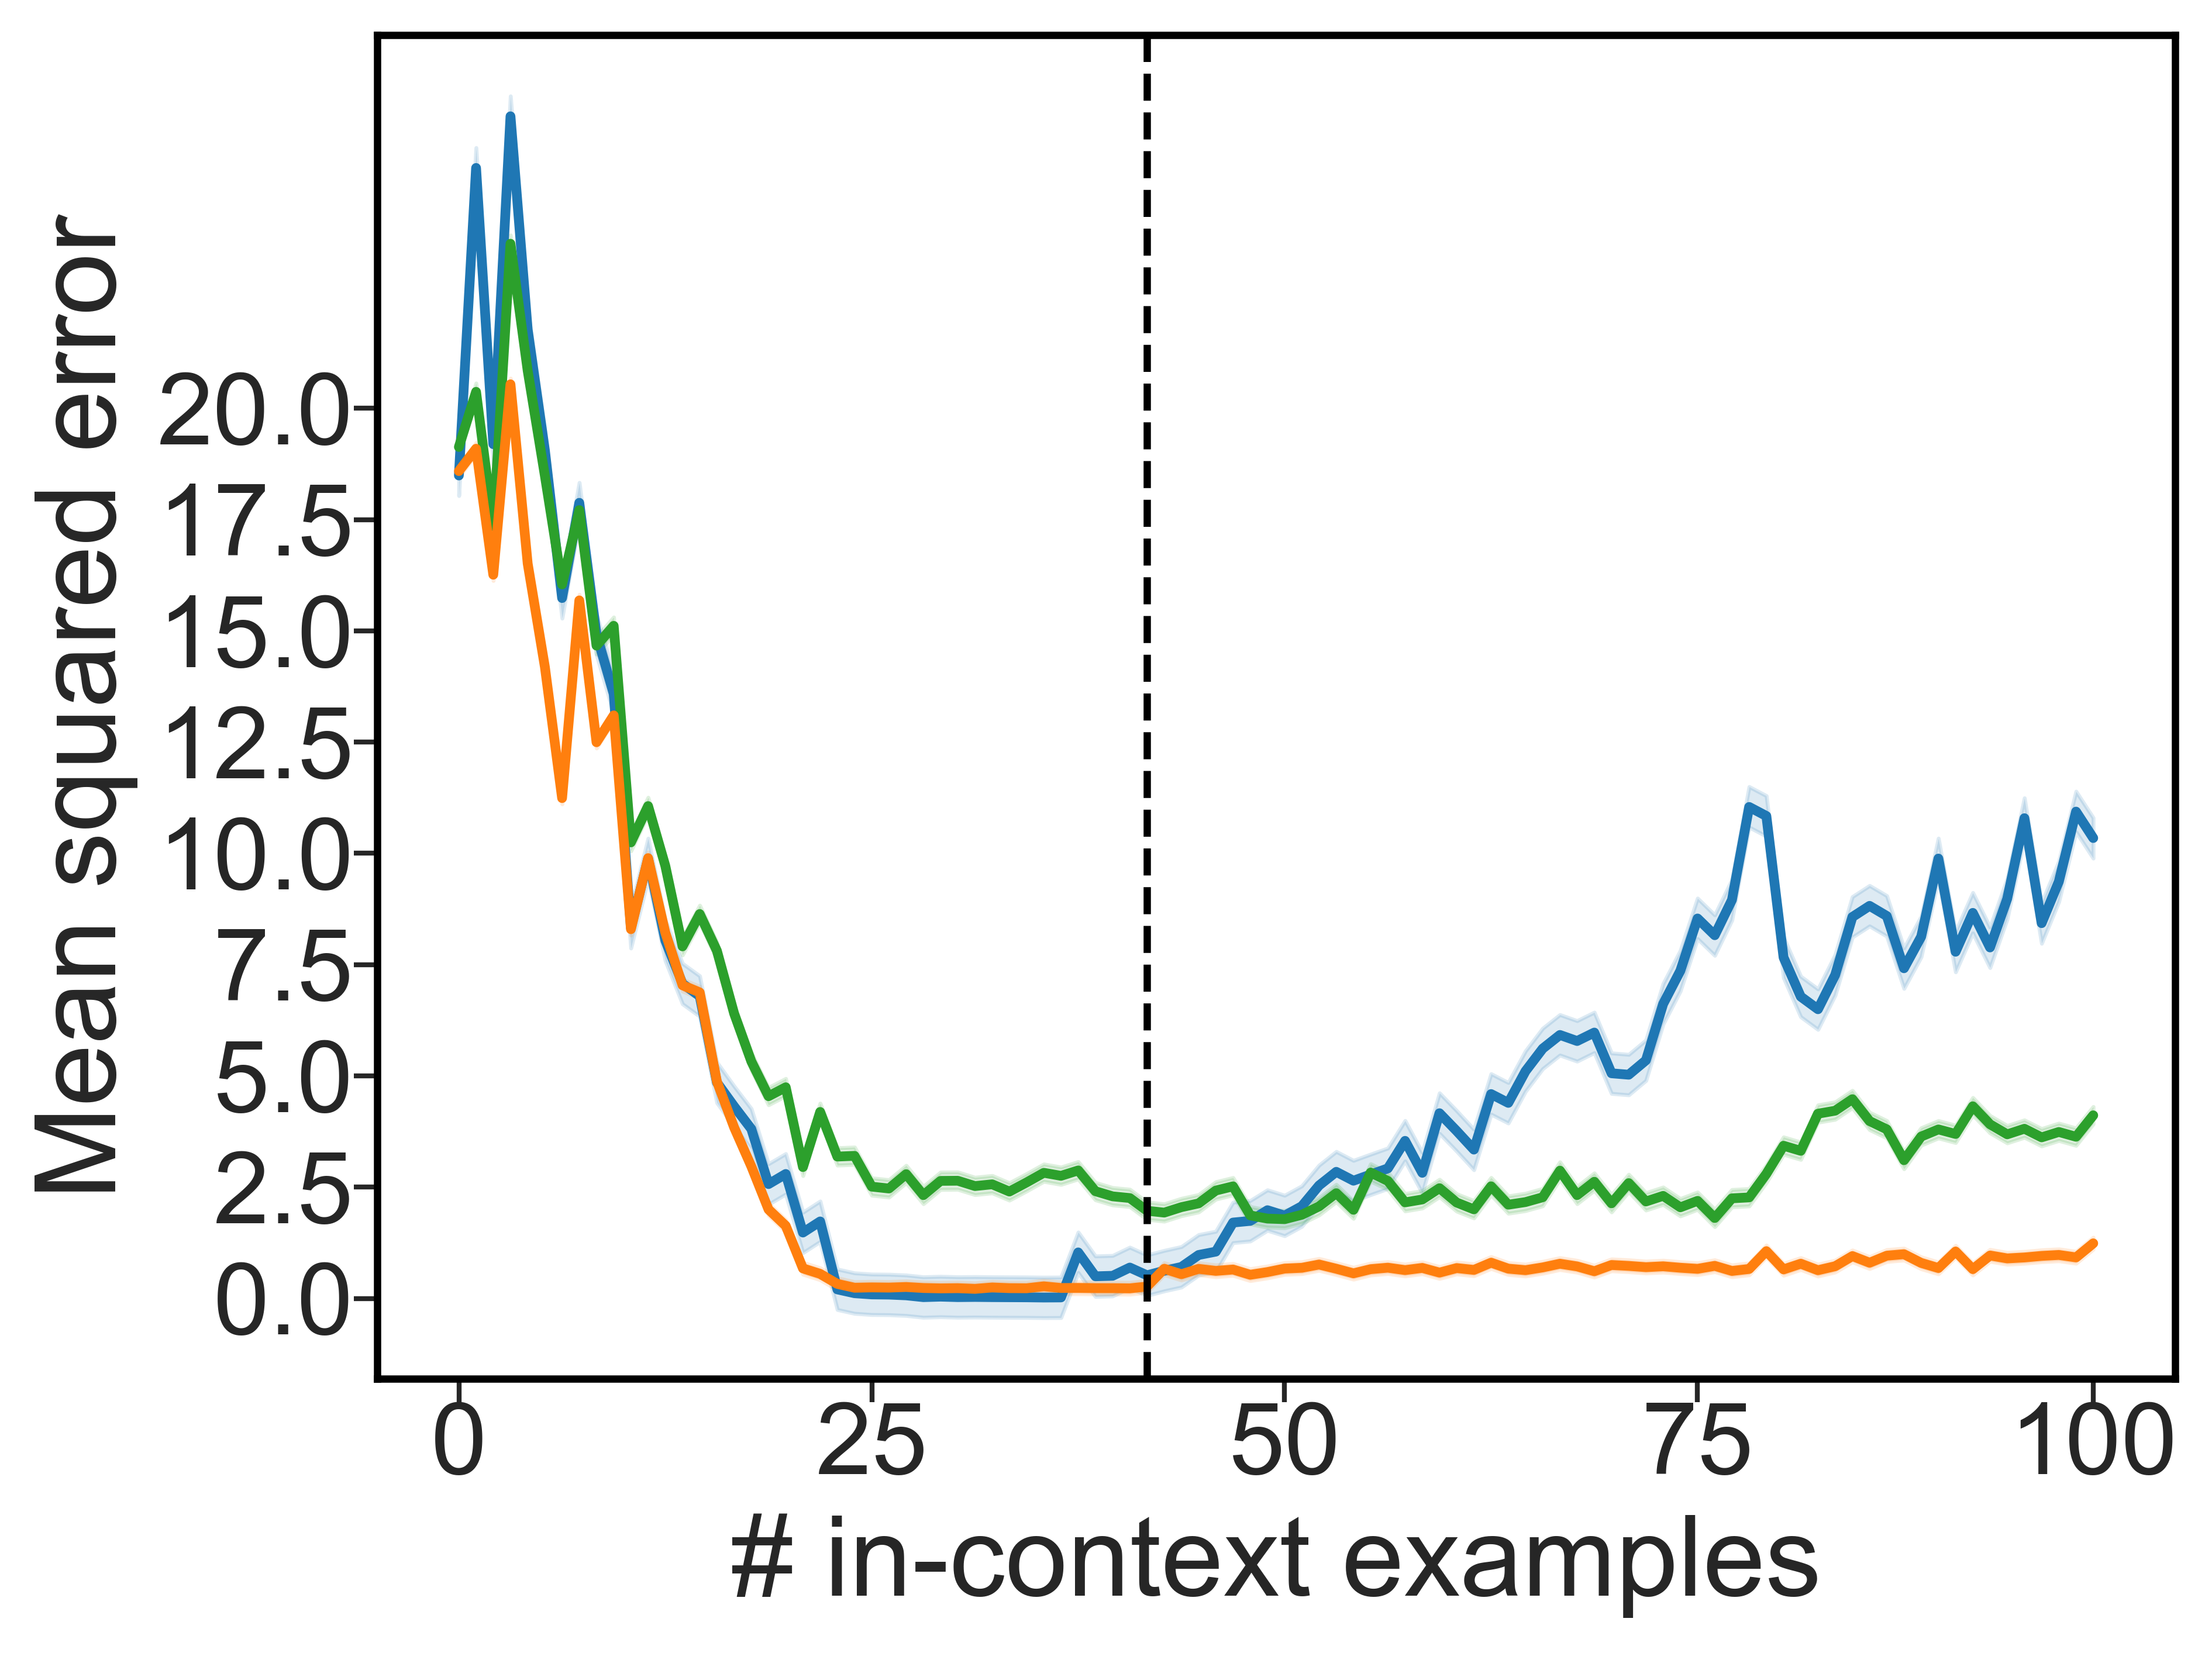

<Figure size 3840x2880 with 0 Axes>

In [10]:
NORM_CURVE = False
COLORS = ['#1f77b4', '#2ca02c', '#ff7f0e']

m = [0.1, 0.25, 0.5, 0.75, 0.9]
scale = 1.0
L = [6, 7, 8]

with torch.no_grad():
    pred = evaluate_model(model, model, xs_test, ys_test, L=1, FV=None, dummy=m, scale=0.0)
    loss = distance(pred, ys_test).cpu().data.numpy()
    
    pred_FV = evaluate_model(model, model, xs_test, ys_test, L=L, FV=FV, dummy=m, scale=scale)
    loss_FV = distance(pred_FV, ys_test).cpu().data.numpy()
    
    pred_LTV = evaluate_model_on_LTV(model, model, xs_test, ys_test, LTV=LTV, dummy=None, scale=1.0)
    loss_LTV = distance(pred_LTV, ys_test).cpu().data.numpy()

    conf_int = compute_confidence_interval((pred - ys_test).cpu().data.numpy() ** 2)
    conf_int_FV = compute_confidence_interval((pred_FV - ys_test).cpu().data.numpy() ** 2)
    conf_int_LTV = compute_confidence_interval((pred_LTV - ys_test).cpu().data.numpy() ** 2)
    
    losses = [loss, loss_FV, loss_LTV]
    legends = ["Transformer", r"Transformer + $v$", r"Transformer + $v_\theta$"]

title = r"$\mathbf{w}$, $\mathbf{x}$ $\sim$ $\mathcal{N}(0, 1)$"

if NORM_CURVE:
    max_value = max(max(loss), max(loss_FV), max(loss_LTV))
    loss = normalize(loss, 0.0, max_value)
    loss_FV = normalize(loss_FV, 0.0, max_value)
    loss_LTV = normalize(loss_LTV, 0.0, max_value)

    y_ticks_max = 1.0
    y_ticks_interval = 0.25
else:
    y_ticks_max = 20.0
    y_ticks_interval = 2.5

plot_transformer(losses,
                 legends,
                 title=None,
                 colors=COLORS,
                 ci_widths=[conf_int, conf_int_FV, conf_int_LTV],
                 x_label="# in-context examples",
                 y_label="Mean squared error",
                 baseline=None,
                 save_path=None,
                 y_ticks_max=3 if dist_shift == "orthogonal_query" else y_ticks_max,
                 y_ticks_interval=1 if dist_shift == "orthogonal_query" else y_ticks_interval,
                 dpi=150,
                 show=True)